### **Importing of Necessary Libraries**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import wandb
from wandb.integration.keras import WandbCallback  # Correct import path
# from kaggle_secrets import UserSecretsClient

# user_secrets = UserSecretsClient()
wandb_api = "e8088d88e26b1a7e7da1fa2751c35f0b5f3d968b"
wandb.login(key=wandb_api)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yuvraj21904 (yuvraj21904-indian-institute-of-information-technology-pune). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\YUVRAJ\_netrc


True

In [17]:
!pip install kaggle_secrets

ERROR: Could not find a version that satisfies the requirement kaggle_secrets (from versions: none)
ERROR: No matching distribution found for kaggle_secrets


### **Dataset Loading and Splitting**
Split-folders library was used to split the dataset into three parts: Training set(60%), Validation set(20%), and Test set(20%).

In [3]:
base_ds = "D://adata"
base_ds = pathlib.Path(base_ds)

In [60]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.50,.20,.30), group_prefix=None)

KeyboardInterrupt: 

In [4]:
Drowsy= [fn for fn in os.listdir(f'{base_ds}\\infected') if (fn.endswith('.png') or fn.endswith('.tif'))]
Non_Drowsy= [fn for fn in os.listdir(f'{base_ds}\\not_infected') if (fn.endswith('.png') or fn.endswith('.png'))]
#Leaf_blight= [fn for fn in os.listdir(f'{base_ds}/Leaf_blight') if (fn.endswith('.JPG') or fn.endswith('.jpeg'))]
#healthy= [fn for fn in os.listdir(f'{base_ds}/healthy') if (fn.endswith('.JPG') or fn.endswith('.jpeg'))]
#Phoma= [fn for fn in os.listdir(f'{base_ds}/Phoma') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
coffee= [Drowsy,Non_Drowsy]
coffee_classes = []
for i in os.listdir('D://adata'):
    coffee_classes+=[i]
coffee_classes.sort()


### **Dataset Exploration**
It can be seen here the total number of images in the dataset, the number of classes, and how well the images from each variety is distributed

Total images: 17784
Total number of classes: 2
Total infected images: 4446
Total not_infected images: 4446


C:\Users\YUVRAJ\AppData\Local\Temp\ipykernel_20852\4208468476.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coffee_classes, y=coffee_count, palette="Blues_d")


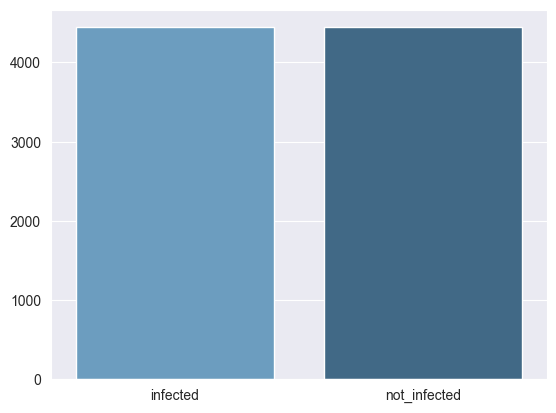

In [5]:
image_count1= len(list(base_ds.glob('*/*.png')))
image_count2 = len(list(base_ds.glob('*/*.PNG')))
image_count=image_count1+image_count2

print(f'Total images: {image_count}')
print(f'Total number of classes: {len(coffee_classes)}')
count = 0
coffee_count = []
for x in coffee_classes:
    print(f'Total {x} images: {len(coffee[count])}')
    coffee_count.append(len(coffee[count]))
    count+=1

sns.set_style('darkgrid')
sns.barplot(x=coffee_classes, y=coffee_count, palette="Blues_d")
plt.show()

### Sample Images
Each image from the dataset has a dimension of 250 by 250 and a color type of RGB

Image dimensions: (244, 244, 3)


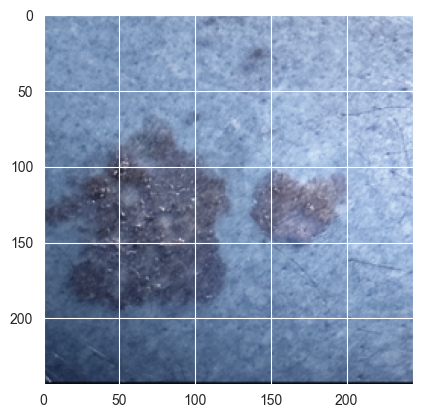

In [90]:
sample_img = cv2.imread("C:\\Users\\YUVRAJ\\imgs\\train\\infected\\IMG_1677_augmented_3.png")
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [91]:
def load_random_img(dir, label):
    plt.figure(figsize=(10,10))
    i=0
    for label in coffee_classes:
        i+=1
        plt.subplot(1,4, i)
        file = random.choice(os.listdir(f'{dir}/{label}'))
        image_path = os.path.join(f'{dir}/{label}', file)
        img=cv2.imread(image_path)
        plt.title(label)
        plt.imshow(img)
        plt.grid(None)
        plt.axis('off')

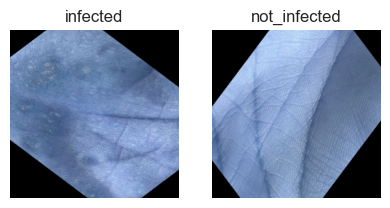

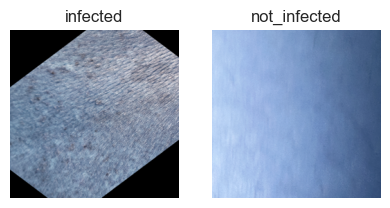

In [92]:
for i in range(2):
    load_random_img(base_ds,coffee_classes)

In [6]:
batch_size =4
img_height, img_width =224,224
input_shape = (img_height, img_width, 3)

CONFIG=dict(
            batch_size =4,
            img_height=224,
            img_width =224,
            )

### **Data Pre-processing**

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               zoom_range=0.15,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.15,
                               horizontal_flip=True,
                               fill_mode="nearest")

test_datagen=ImageDataGenerator(rescale=1./255)

In [8]:
train_ds = train_datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical',
    shuffle=True
    )

val_ds = train_datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = test_datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 5091 images belonging to 2 classes.
Found 2037 images belonging to 2 classes.
Found 3059 images belonging to 2 classes.


In [78]:
from PIL import Image
import os

def verify_images(directory):
    for filename in os.listdir(directory):
        try:
            img_path = os.path.join(directory, filename)
            with Image.open(img_path) as img:
                img.verify()  # Verify if the file is a valid image
        except (IOError, SyntaxError) as e:
            print(f"Corrupted or invalid image: {filename}")
            os.remove(img_path)

# Replace with your dataset directory path
verify_images("C:\\Users\\YUVRAJ\\imgs\\train\\infected")
verify_images("C:\\Users\\YUVRAJ\\imgs\\train\\not_infected")
verify_images("C:\\Users\\YUVRAJ\\imgs\\val\\infected")
verify_images("C:\\Users\\YUVRAJ\\imgs\\val\\not_infected")
verify_images("C:\\Users\\YUVRAJ\\imgs\\test\\infected")
verify_images("C:\\Users\\YUVRAJ\\imgs\\test\\not_infected")


Corrupted or invalid image: IMG_2041_augmented_2.png
Corrupted or invalid image: IMG_1237_augmented_1.png


In [9]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [9]:
CONFIG['model_name'] = 'DenseNet121'
print('Training configuration: ', CONFIG)

# Initialize W&B run
run = wandb.init(settings=wandb.Settings(start_method="spawn"),
                 reinit=True,
                 project='arsenic',
                 entity="yuvraj21904-indian-institute-of-information-technology-pune",
                 config=CONFIG,
                 group='DenseNet121', 
                 job_type='train')

wandb.config.type = 'baseline'

Training configuration:  {'batch_size': 4, 'img_height': 224, 'img_width': 224, 'model_name': 'DenseNet121'}


In [69]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## **Transfer Learning**

In [10]:
model=tf.keras.applications.DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
model.trainable = True
inputs = tf.keras.Input(input_shape)
x = model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)
model= tf.keras.Model(inputs, x)

29084464/29084464 [==============================] - 5s 0us/step


In [11]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 8,089,154
Trainable params: 8,005,506
Non-trainable params: 83,648
______________________________________________

## **Fine Tuning**

In [12]:
history3 =model.fit(train_ds, epochs =30, validation_data = val_ds,callbacks=[WandbCallback(save_graph=False,save_model = False)])
run.finish()

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Epoch 1/30
1273/1273 [==============================] - 213s 154ms/step - loss: 0.2413 - accuracy: 0.8986 - val_loss: 0.1013 - val_accuracy: 0.9543
Epoch 2/30
1273/1273 [==============================] - 186s 146ms/step - loss: 0.1047 - accuracy: 0.9601 - val_loss: 0.1208 - val_accuracy: 0.9475
Epoch 3/30
1273/1273 [==============================] - 183s 144ms/step - loss: 0.0666 - accuracy: 0.9760 - val_loss: 0.0983 - val_accuracy: 0.9627
Epoch 4/30
1273/1273 [==============================] - 195s 153ms/step - loss: 0.0512 - accuracy: 0.9839 - val_loss: 0.0325 - val_accuracy: 0.9897
Epoch 5/30
1273/1273 [==============================] - 191s 150ms/step - loss: 0.0389 - accuracy: 0.9853 - val_loss: 0.1095 - val_accuracy: 0.9612
Epoch 6/30
1273/1273 [==============================] - 180s 141ms/step - loss: 0.0321 - accuracy: 0.9900 - val_loss: 0.0278 - val_accuracy: 0.9887
Epoch 7/30
1273/1273 [==============================] - 182s 143ms/step - loss: 0.0349 - accuracy: 0.9890 - val_

accuracy,▁▅▆▇▇▇▇▇▇█▇███████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▁▃▇▃▆▇▆▇█▇█▄█▆█▅███▇██▃█▇█▇█▇
val_loss,▆▇▆▃▆▂▂▃▂▁▂▁▅▁▄▁▃▁▁▁▂▁▁█▁▂▁▂▁▂
accuracy,0.99489
best_epoch,18
best_val_loss,0.00068
epoch,29
loss,0.01876
val_accuracy,0.99067


## **Final Evaluation**

In [13]:
run = wandb.init(settings=wandb.Settings(start_method="spawn"),
                 reinit=True,
                 project='arsenic', 
                 config=CONFIG,
                 group='DenseNet121', 
                 job_type='evaluate') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Evaluate model
score3 =model.evaluate(test_ds, verbose=1)

# Finish the run
run.finish()

765/765 [==============================] - 46s 60ms/step - loss: 0.0114 - accuracy: 0.9967


In [14]:
print(f'Pretrained Network Fine-tuned "\n"Loss: {score3[0]},"\n" Accuracy: {score3[1]*100}')

Pretrained Network Fine-tuned "
"Loss: 0.011437605135142803,"
" Accuracy: 99.67309832572937


In [15]:
Y_pred =model.predict(test_ds)

765/765 [==============================] - 43s 54ms/step


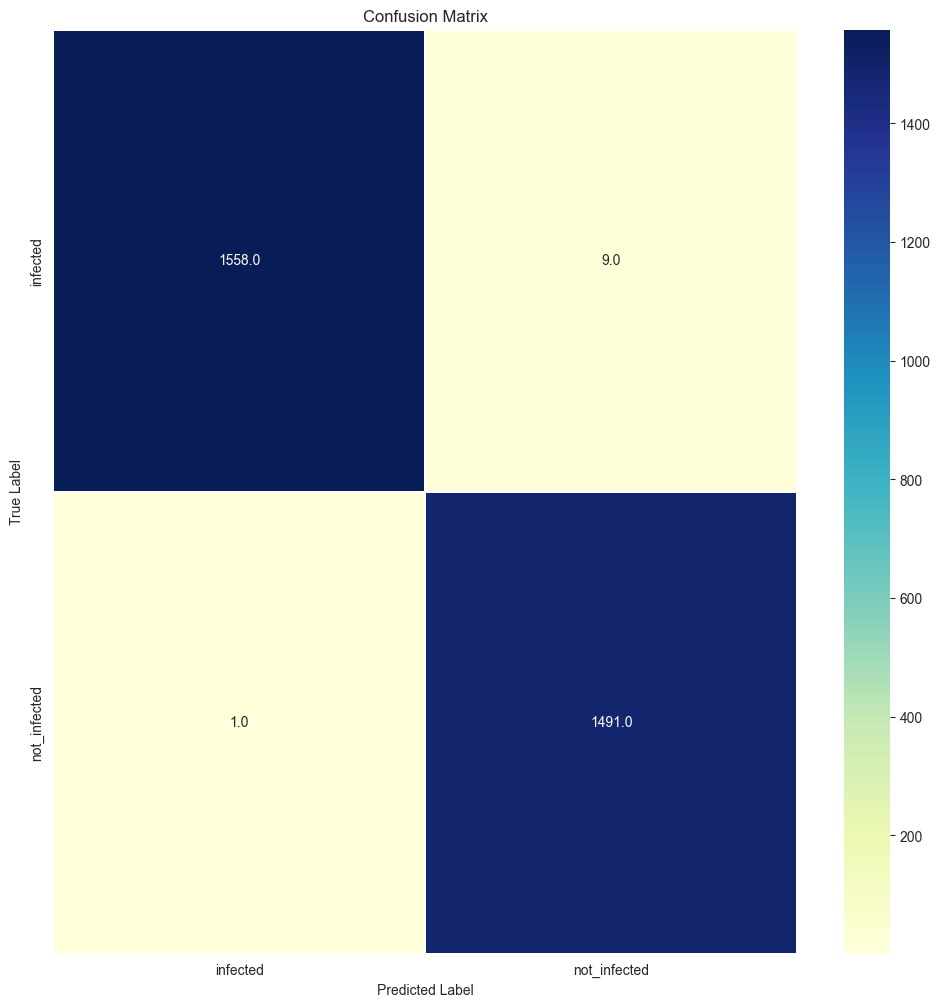

In [16]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,
           cmap="YlGnBu",)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(coffee_classes)
plt.title("Confusion Matrix")
plt.show()

In [17]:
report2 = classification_report(test_ds.classes, y_pred, target_names=coffee_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

,precision,recall,f1-score,support
infected,0.994257,0.999359,0.996801,1559.000000
not_infected,0.999330,0.994000,0.996658,1500.000000
accuracy,0.996731,0.996731,0.996731,0.996731
macro avg,0.996793,0.996679,0.996729,3059.000000
weighted avg,0.996744,0.996731,0.996731,3059.000000


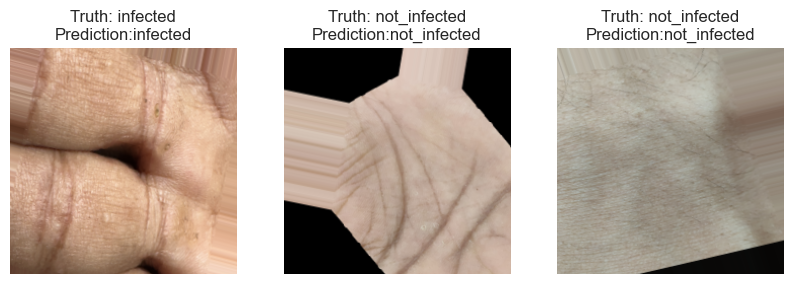

In [18]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(3):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict =model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label =coffee_classes[np.argmax(score)]
    plt.title(f'Truth: {coffee_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)
    


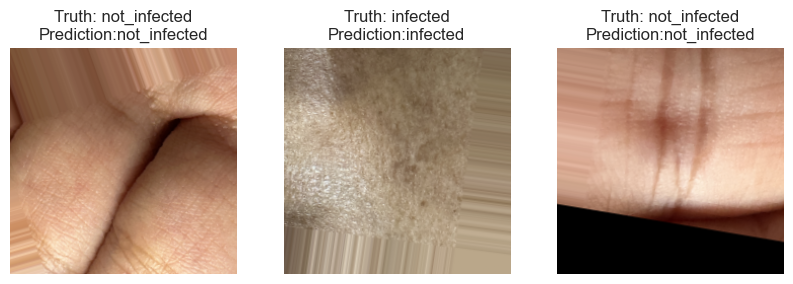

In [19]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(3):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict =model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label =coffee_classes[np.argmax(score)]
    plt.title(f'Truth: {coffee_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

In [20]:
model.save('DenseNet121-baseline.h5')

# Initialize a new W&B run
run = wandb.init(settings=wandb.Settings(start_method="spawn"),
                 reinit=True,
                 project='arsenic', 
                 config=CONFIG,
                 group='DenseNet121', 
                 job_type='save') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Save model as Model Artifact
artifact = wandb.Artifact(name='DenseNet121', type='model')
artifact.add_file('DenseNet121-baseline.h5')
run.log_artifact(artifact)

# Finish W&B run
run.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yuvraj21904 (yuvraj21904-indian-institute-of-information-technology-pune). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\YUVRAJ\_netrc


Available keys in the history:
Index(['val_loss', '_timestamp', 'val_accuracy', 'loss', '_step', 'epoch',
       '_runtime', 'accuracy'],
      dtype='object')

Sample rows from history:
   val_loss    _timestamp  val_accuracy      loss  _step  epoch    _runtime  \
0  0.101287  1.730472e+09      0.954345  0.241254      0      0  225.626645   
1  0.120849  1.730473e+09      0.947472  0.104671      1      1  411.564065   
2  0.098326  1.730473e+09      0.962690  0.066592      2      2  594.373746   
3  0.032533  1.730473e+09      0.989691  0.051173      3      3  789.249598   
4  0.109465  1.730473e+09      0.961217  0.038883      4      4  980.126163   

   accuracy  
0  0.898645  
1  0.960126  
2  0.976036  
3  0.983893  
4  0.985268  

Available keys in the summary:
dict_keys(['_runtime', '_step', '_timestamp', '_wandb', 'accuracy', 'best_epoch', 'best_val_loss', 'epoch', 'loss', 'val_accuracy', 'val_loss'])


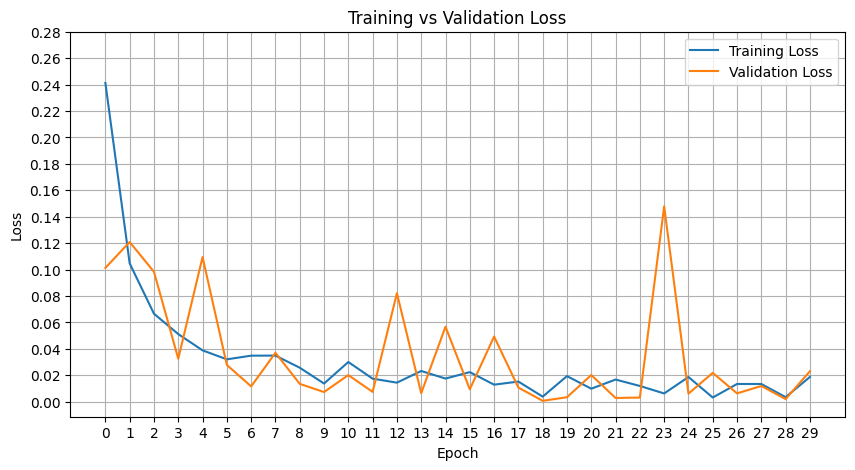

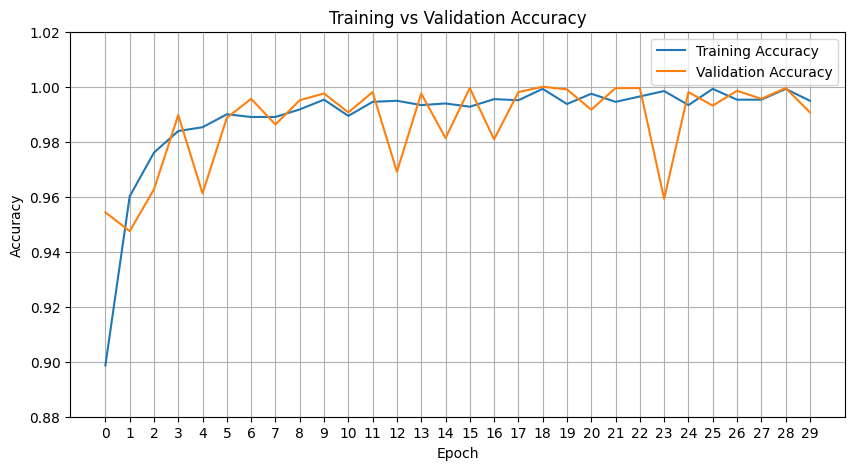

In [1]:
import wandb
from wandb.integration.keras import WandbCallback  # Correct import path
# from kaggle_secrets import UserSecretsClient

# user_secrets = UserSecretsClient()
wandb_api = "e8088d88e26b1a7e7da1fa2751c35f0b5f3d968b"
wandb.login(key=wandb_api)




import matplotlib.pyplot as plt

# Initialize a W&B API client
api = wandb.Api()

# Fetch a specific run by project and run id
# Replace 'your-project-name' and 'your-run-id' with the actual project and run ID
project_name = 'arsenic'
run_id = 'mq5s014l'
run = api.run(f"{project_name}/{run_id}")

# Fetch the history of the run (including all logged metrics)
history = run.history()
print("Available keys in the history:")
print(history.columns)

# Optional: Print a few rows to understand the data structure
print("\nSample rows from history:")
print(history.head())

# Print keys in the summary
print("\nAvailable keys in the summary:")
print(run.summary.keys())



import numpy as np
steps = history['epoch']
train_loss = history['loss']
val_loss = history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.xticks(np.arange(min(steps), max(steps) + 1, 1))  # X-axis ticks every 1 step-axis ticks every 0.02

y_min = np.floor(min(min(train_loss), min(val_loss)) / 0.02) * 0.02
y_max = np.ceil(max(max(train_loss), max(val_loss)) / 0.02) * 0.02
plt.yticks(np.arange(y_min, y_max + 0.02, 0.02))  # Y-axis ticks every 0.02

plt.show()


steps = history['epoch']
train_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

plt.figure(figsize=(10, 5))
plt.plot(steps, train_accuracy, label='Training Accuracy')
plt.plot(steps, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.xticks(np.arange(min(steps), max(steps) + 1, 1)) 

y_min = np.floor(min(min(train_accuracy), min(val_accuracy)) / 0.02) * 0.02
y_max = np.ceil(max(max(train_accuracy), max(val_accuracy)) / 0.02) * 0.02
plt.yticks(np.arange(y_min, y_max + 0.02, 0.02)) 

plt.show()

<h2>Support by giving an upvote!!</h2>